In [11]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Verifica se CUDA (GPU) está disponível e define o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


Carregamos o modelo ResNet18, que foi previamente treinado em ImageNet. Ao definir `pretrained=True`, os pesos do modelo já treinados são baixados automaticamente. Colocamos o modelo em modo de avaliação `(model_pretrained.eval())` e o movemos para o dispositivo que estamos usando.

Modelo pré-treinado ResNet18 carregado e em modo de avaliação.

Transformações a serem aplicadas na imagem de entrada:
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


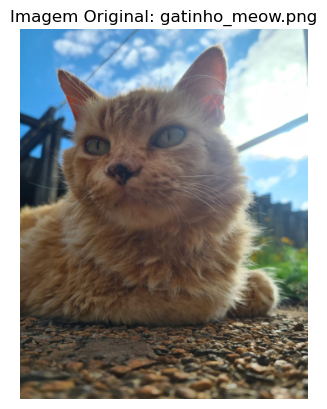


Rótulos do ImageNet carregados de 'imagenet-simple-labels.json'.

Top 5 predições para 'gatinho meow.png':
- Persian cat: 34.93%
- tabby cat: 24.02%
- Egyptian Mau: 16.79%
- Siamese cat: 6.87%
- tiger cat: 5.19%


In [13]:
# Carrega o modelo ResNet18 pré-treinado
# weights=models.ResNet18_Weights.IMAGENET1K_V1 garante que estamos usando os pesos padrão do ImageNet
model_resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Coloca o modelo em modo de avaliação (importante para desativar camadas como Dropout, BatchNorm)
model_resnet18.eval()

# Move o modelo para o dispositivo (CPU ou GPU)
model_resnet18.to(device)

print("Modelo pré-treinado ResNet18 carregado e em modo de avaliação.")

# Define as transformações que o modelo ResNet espera (padrão do ImageNet)
# Essas transformações foram usadas durante o treinamento do modelo no ImageNet.
preprocess_transform = models.ResNet18_Weights.IMAGENET1K_V1.transforms()
print("\nTransformações a serem aplicadas na imagem de entrada:")
print(preprocess_transform)

# Carrega a imagem do gato usando PIL
# Certifique-se que 'gatinho_meow.png' está no mesmo diretório do notebook, ou forneça o caminho completo.
image_path_cat = "gatinho meow.png" # Substitua pelo nome/caminho correto se necessário

try:
    img_cat = Image.open(image_path_cat).convert('RGB') # Garante que a imagem esteja em formato RGB

    # Aplica as transformações de pré-processamento
    img_cat_transformed = preprocess_transform(img_cat)

    # Adiciona uma dimensão de batch (o modelo espera batches de imagens: [N, C, H, W])
    batch_cat = torch.unsqueeze(img_cat_transformed, 0)

    # Move o batch para o dispositivo
    batch_cat = batch_cat.to(device)

    # Mostra a imagem original
    plt.imshow(img_cat)
    plt.title("Imagem Original: gatinho_meow.png")
    plt.axis('off') # Remove os eixos
    plt.show()

    # --- Realizando a Inferência ---
    with torch.no_grad(): # Desativa o cálculo de gradientes para a inferência
        output_cat = model_resnet18(batch_cat)

    # As saídas são logits. Aplicamos softmax para obter probabilidades.
    probabilities_cat = torch.nn.functional.softmax(output_cat, dim=1)[0]

    # Obtém os índices e probabilidades das 5 classes com maior score
    top5_prob_cat, top5_indices_cat = torch.topk(probabilities_cat, 5)
    
    # Move para CPU para manipulação com Python/NumPy e impressão
    top5_prob_cat_cpu = top5_prob_cat.cpu()
    top5_indices_cat_cpu = top5_indices_cat.cpu()

    # Carrega os rótulos do ImageNet do arquivo JSON local
    # O arquivo 'imagenet-simple-labels.json' deve estar no mesmo diretório.
    labels_file_path_cat = "imagenet-simple-labels.json"
    imagenet_labels = None
    try:
        with open(labels_file_path_cat, 'r') as f:
            imagenet_labels = json.load(f) # O JSON é uma lista de strings
        print(f"\nRótulos do ImageNet carregados de '{labels_file_path_cat}'.")
    except FileNotFoundError:
        print(f"ERRO: Arquivo de rótulos '{labels_file_path_cat}' não encontrado.")
    except json.JSONDecodeError:
        print(f"ERRO: O arquivo de rótulos '{labels_file_path_cat}' não é um JSON válido.")

    # Imprime as 5 principais predições
    if imagenet_labels:
        print("\nTop 5 predições para 'gatinho meow.png':")
        for i in range(top5_prob_cat_cpu.size(0)):
            class_index = top5_indices_cat_cpu[i].item()
            # Acessa o rótulo diretamente pelo índice, pois 'imagenet_labels' é uma lista
            class_name = imagenet_labels[class_index] if 0 <= class_index < len(imagenet_labels) else f"Índice fora do intervalo ({class_index})"
            probability = top5_prob_cat_cpu[i].item() * 100
            print(f"- {class_name}: {probability:.2f}%")
    else:
        print("\nNão foi possível exibir os nomes das classes pois os rótulos não foram carregados.")

except FileNotFoundError:
    print(f"ERRO: Imagem '{image_path_cat}' não encontrada. Verifique o caminho e o nome do arquivo.")
except Exception as e:
    print(f"Ocorreu um erro inesperado ao processar a imagem do gato: {e}")

Modelo Faster R-CNN pré-treinado carregado.


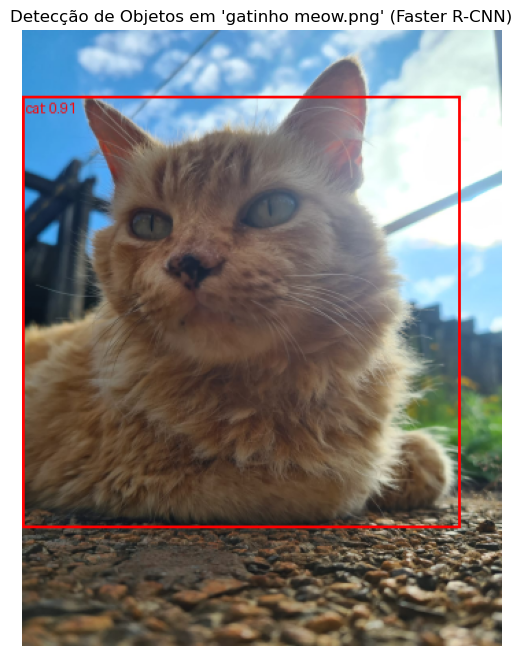


Objetos detectados (com score > 0.5 ):
- cat: 0.91


In [18]:
import torch
import torchvision.models.detection as detection_models
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.utils as utils
import random # Para selecionar cores aleatórias para as boxes

# Carrega o modelo Faster R-CNN pré-treinado com um backbone ResNet50 FPN
# weights=detection_models.FasterRCNN_ResNet50_FPN_Weights.COCO_V1
model_frcnn = detection_models.fasterrcnn_resnet50_fpn(weights=detection_models.FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
model_frcnn.eval() # Modo de avaliação
model_frcnn.to(device)
print("Modelo Faster R-CNN pré-treinado carregado.")

# Rótulos das classes do COCO (o Faster R-CNN pré-treinado no torchvision usa estes)
# Fonte: https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Carrega uma imagem de exemplo para detecção
image_path_detection = "gatinho meow.png" # Ou outra imagem de sua escolha

try:
    img_detection_pil = Image.open(image_path_detection).convert("RGB")

    # Transforma a imagem para tensor
    transform_detection = T.Compose([T.ToTensor()])
    img_detection_tensor = transform_detection(img_detection_pil)

    # Adiciona a dimensão do batch e move para o dispositivo
    img_detection_batch = img_detection_tensor.unsqueeze(0).to(device)

    # --- Realizando a Inferência para Detecção ---
    with torch.no_grad():
        predictions_detection = model_frcnn(img_detection_batch)

    # 'predictions_detection' é uma lista (com um elemento, pois o batch_size é 1).
    # Cada elemento é um dicionário com 'boxes', 'labels', 'scores'.
    pred = predictions_detection[0]

    # Filtra as detecções com score > 0.5 (você pode ajustar este limiar)
    score_threshold = 0.5
    confident_detections_indices = pred['scores'] > score_threshold
    
    filtered_boxes = pred['boxes'][confident_detections_indices].cpu()
    filtered_labels_indices = pred['labels'][confident_detections_indices].cpu().tolist()
    filtered_scores = pred['scores'][confident_detections_indices].cpu().tolist()

    # Converte os índices dos rótulos para nomes
    filtered_labels_names = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in filtered_labels_indices]
    
    # Prepara as labels para desenhar nas caixas (nome da classe + score)
    labels_to_draw = [f"{name}: {score:.2f}" for name, score in zip(filtered_labels_names, filtered_scores)]

    # Gera cores aleatórias para as caixas
    # (Se houver poucas classes, você pode definir cores fixas)
    box_colors = []
    for _ in range(len(filtered_boxes)):
        box_colors.append(random.choice(['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'cyan']))
        
    # Desenha as bounding boxes na imagem original (convertida para tensor uint8)
    # A imagem original precisa estar no formato (C, H, W) e ser um tensor uint8.
    img_to_draw_on = (T.ToTensor()(img_detection_pil) * 255).to(torch.uint8)

    if len(filtered_boxes) > 0:
        img_with_boxes = utils.draw_bounding_boxes(
            image=img_to_draw_on,
            boxes=filtered_boxes,
            labels=labels_to_draw,
            colors=box_colors,
            width=2 # Largura da linha da caixa
        )
    else:
        print("Nenhum objeto detectado com confiança >", score_threshold)
        img_with_boxes = img_to_draw_on # Mostra a imagem original se nada for detectado

    # Converte de volta para imagem PIL para exibir com matplotlib
    plt_img_with_boxes = T.ToPILImage()(img_with_boxes)

    plt.figure(figsize=(10, 8))
    plt.imshow(plt_img_with_boxes)
    plt.title(f"Detecção de Objetos em '{image_path_detection}' (Faster R-CNN)")
    plt.axis('off')
    plt.show()

    print("\nObjetos detectados (com score >", score_threshold, "):")
    for label, score in zip(filtered_labels_names, filtered_scores):
        print(f"- {label}: {score:.2f}")
        
except FileNotFoundError:
    print(f"ERRO: Imagem '{image_path_detection}' não encontrada.")
except Exception as e:
    print(f"Ocorreu um erro ao processar a detecção de objetos: {e}")

A detecção de objetos vai além da classificação. O objetivo é não apenas dizer o que está na imagem, mas também onde está, desenhando uma caixa delimitadora (bounding box) ao redor de cada objeto de interesse.

Bounding Box: Geralmente representada por 4 coordenadas, como (x_min, y_min, x_max, y_max) que definem o retângulo ao redor do objeto.
Saída do Modelo: Um modelo de detecção de objetos normalmente retorna: 

A classe de cada objeto detectado.
As coordenadas da bounding box para cada objeto.
Um score de confiança para cada detecção.
Avaliação: Métricas como a Interseção sobre União (IoU) são usadas para avaliar a precisão das bounding boxes preditas em relação às caixas verdadeiras (ground truth).
Pós-processamento: Técnicas como a Supressão Não-Máxima (NMS) são frequentemente aplicadas para remover detecções redundantes ou com baixa confiança.

Modelos Pré-Treinados para Detecção de Objetos:

`torchvision.models.detection` oferece modelos pré-treinados como:

1. Faster R-CNN 
2. Mask R-CNN (que também faz segmentação de instância) 
3. RetinaNet
4. SSD (Single Shot MultiBox Detector)

Modelo Faster R-CNN pré-treinado carregado.


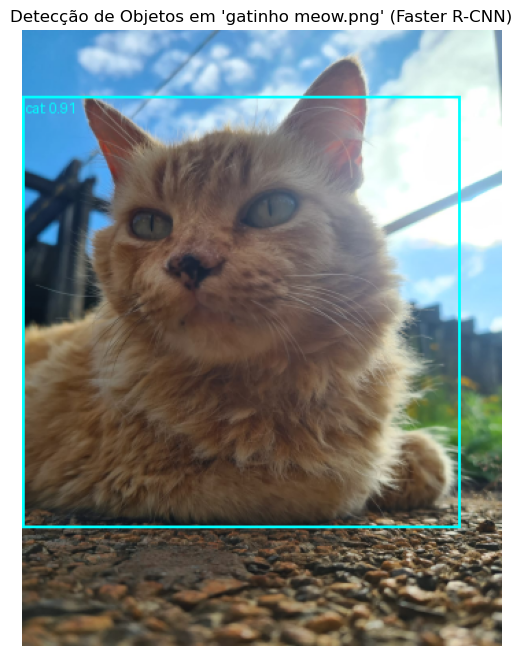


Objetos detectados (com score > 0.5 ):
- cat: 0.91


In [17]:
import torch
import torchvision.models.detection as detection_models
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.utils as utils
import random # Para selecionar cores aleatórias para as boxes

# Carrega o modelo Faster R-CNN pré-treinado com um backbone ResNet50 FPN
# weights=detection_models.FasterRCNN_ResNet50_FPN_Weights.COCO_V1
model_frcnn = detection_models.fasterrcnn_resnet50_fpn(weights=detection_models.FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
model_frcnn.eval() # Modo de avaliação
model_frcnn.to(device)
print("Modelo Faster R-CNN pré-treinado carregado.")

# Rótulos das classes do COCO (o Faster R-CNN pré-treinado no torchvision usa estes)
# Fonte: https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Carrega uma imagem de exemplo para detecção
image_path_detection = "gatinho meow.png" # Ou outra imagem de sua escolha

try:
    img_detection_pil = Image.open(image_path_detection).convert("RGB")

    # Transforma a imagem para tensor
    transform_detection = T.Compose([T.ToTensor()])
    img_detection_tensor = transform_detection(img_detection_pil)

    # Adiciona a dimensão do batch e move para o dispositivo
    img_detection_batch = img_detection_tensor.unsqueeze(0).to(device)

    # --- Realizando a Inferência para Detecção ---
    with torch.no_grad():
        predictions_detection = model_frcnn(img_detection_batch)

    # 'predictions_detection' é uma lista (com um elemento, pois o batch_size é 1).
    # Cada elemento é um dicionário com 'boxes', 'labels', 'scores'.
    pred = predictions_detection[0]

    # Filtra as detecções com score > 0.5 (você pode ajustar este limiar)
    score_threshold = 0.5
    confident_detections_indices = pred['scores'] > score_threshold
    
    filtered_boxes = pred['boxes'][confident_detections_indices].cpu()
    filtered_labels_indices = pred['labels'][confident_detections_indices].cpu().tolist()
    filtered_scores = pred['scores'][confident_detections_indices].cpu().tolist()

    # Converte os índices dos rótulos para nomes
    filtered_labels_names = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in filtered_labels_indices]
    
    # Prepara as labels para desenhar nas caixas (nome da classe + score)
    labels_to_draw = [f"{name}: {score:.2f}" for name, score in zip(filtered_labels_names, filtered_scores)]

    # Gera cores aleatórias para as caixas
    # (Se houver poucas classes, você pode definir cores fixas)
    box_colors = []
    for _ in range(len(filtered_boxes)):
        box_colors.append(random.choice(['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'cyan']))
        
    # Desenha as bounding boxes na imagem original (convertida para tensor uint8)
    # A imagem original precisa estar no formato (C, H, W) e ser um tensor uint8.
    img_to_draw_on = (T.ToTensor()(img_detection_pil) * 255).to(torch.uint8)

    if len(filtered_boxes) > 0:
        img_with_boxes = utils.draw_bounding_boxes(
            image=img_to_draw_on,
            boxes=filtered_boxes,
            labels=labels_to_draw,
            colors=box_colors,
            width=2 # Largura da linha da caixa
        )
    else:
        print("Nenhum objeto detectado com confiança >", score_threshold)
        img_with_boxes = img_to_draw_on # Mostra a imagem original se nada for detectado

    # Converte de volta para imagem PIL para exibir com matplotlib
    plt_img_with_boxes = T.ToPILImage()(img_with_boxes)

    plt.figure(figsize=(10, 8))
    plt.imshow(plt_img_with_boxes)
    plt.title(f"Detecção de Objetos em '{image_path_detection}' (Faster R-CNN)")
    plt.axis('off')
    plt.show()

    print("\nObjetos detectados (com score >", score_threshold, "):")
    for label, score in zip(filtered_labels_names, filtered_scores):
        print(f"- {label}: {score:.2f}")
        
except FileNotFoundError:
    print(f"ERRO: Imagem '{image_path_detection}' não encontrada.")
except Exception as e:
    print(f"Ocorreu um erro ao processar a detecção de objetos: {e}")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /home/raulm/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|████████████████████████████████████████████████████████████| 170M/170M [00:05<00:00, 30.6MB/s]


Modelo Mask R-CNN pré-treinado carregado.


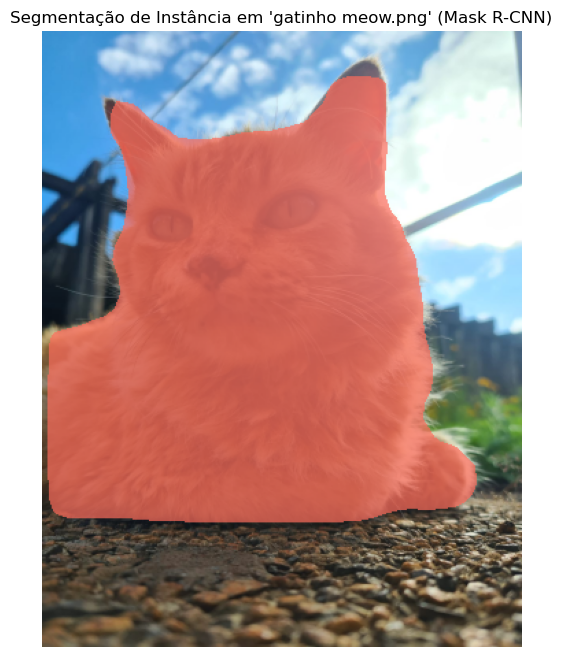


Instâncias segmentadas (com score > 0.5 ):
- cat: 0.98


In [19]:
import torch
import torchvision.models.detection as detection_models
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.utils as utils
import numpy as np # Para manipulação de máscaras
import random # Para cores

# Carrega o modelo Mask R-CNN pré-treinado
model_maskrcnn = detection_models.maskrcnn_resnet50_fpn(weights=detection_models.MaskRCNN_ResNet50_FPN_Weights.COCO_V1)
model_maskrcnn.eval()
model_maskrcnn.to(device)
print("Modelo Mask R-CNN pré-treinado carregado.")

# Carrega uma imagem de exemplo. 
image_path_segmentation = "gatinho meow.png" 

try:
    img_seg_pil = Image.open(image_path_segmentation).convert("RGB")

    transform_segmentation = T.Compose([T.ToTensor()])
    img_seg_tensor = transform_segmentation(img_seg_pil)
    img_seg_batch = img_seg_tensor.unsqueeze(0).to(device)

    # --- Realizando a Inferência para Segmentação de Instância ---
    with torch.no_grad():
        predictions_segmentation = model_maskrcnn(img_seg_batch)

    pred_seg = predictions_segmentation[0] # Saída para a primeira (e única) imagem no batch

    # Filtra detecções com score > 0.5
    score_threshold_seg = 0.5
    confident_indices_seg = pred_seg['scores'] > score_threshold_seg
    
    filtered_masks_seg = pred_seg['masks'][confident_indices_seg].cpu().squeeze(1) # Remove dimensão do canal se for 1
    filtered_labels_indices_seg = pred_seg['labels'][confident_indices_seg].cpu().tolist()
    filtered_scores_seg = pred_seg['scores'][confident_indices_seg].cpu().tolist()
    
    filtered_labels_names_seg = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in filtered_labels_indices_seg]

    # Desenha as máscaras na imagem
    # A imagem original como tensor uint8
    img_to_draw_masks_on = (T.ToTensor()(img_seg_pil) * 255).to(torch.uint8)
    
    if len(filtered_masks_seg) > 0:
        # Cria cores aleatórias para as máscaras de cada instância
        # As máscaras do Mask R-CNN são soft masks (valores entre 0 e 1) [cite: 125]
        # Para desenhar, geralmente binarizamos com um limiar (ex: 0.5) e aplicamos a cor.
        # torchvision.utils.draw_segmentation_masks espera máscaras booleanas.
        
        boolean_masks = filtered_masks_seg > 0.5 # Binariza as máscaras
        
        # Gera cores para cada máscara
        mask_colors = []
        for _ in range(len(boolean_masks)):
            mask_colors.append(tuple(np.random.randint(50, 256, size=3).tolist())) # Cores RGB aleatórias mais vivas

        # 'draw_segmentation_masks' desenha as máscaras. Alpha controla a transparência.
        img_with_masks = utils.draw_segmentation_masks(
            image=img_to_draw_masks_on,
            masks=boolean_masks,
            alpha=0.7, # Transparência da máscara
            colors=mask_colors
        )
    else:
        print("Nenhuma instância segmentada com confiança >", score_threshold_seg)
        img_with_masks = img_to_draw_masks_on

    plt_img_with_masks = T.ToPILImage()(img_with_masks)

    plt.figure(figsize=(10, 8))
    plt.imshow(plt_img_with_masks)
    plt.title(f"Segmentação de Instância em '{image_path_segmentation}' (Mask R-CNN)")
    plt.axis('off')
    plt.show()
    
    print("\nInstâncias segmentadas (com score >", score_threshold_seg, "):")
    for label, score in zip(filtered_labels_names_seg, filtered_scores_seg):
        print(f"- {label}: {score:.2f}")

except FileNotFoundError:
    print(f"ERRO: Imagem '{image_path_segmentation}' não encontrada.")
except Exception as e:
    print(f"Ocorreu um erro ao processar a segmentação de instância: {e}")

Usando dispositivo: cpu
Usando modelo Mask R-CNN previamente carregado.


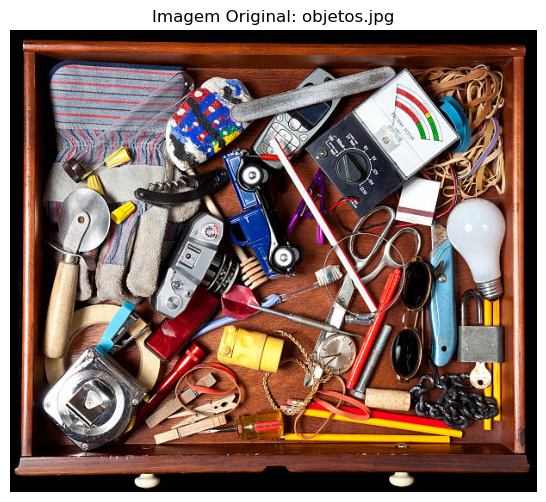

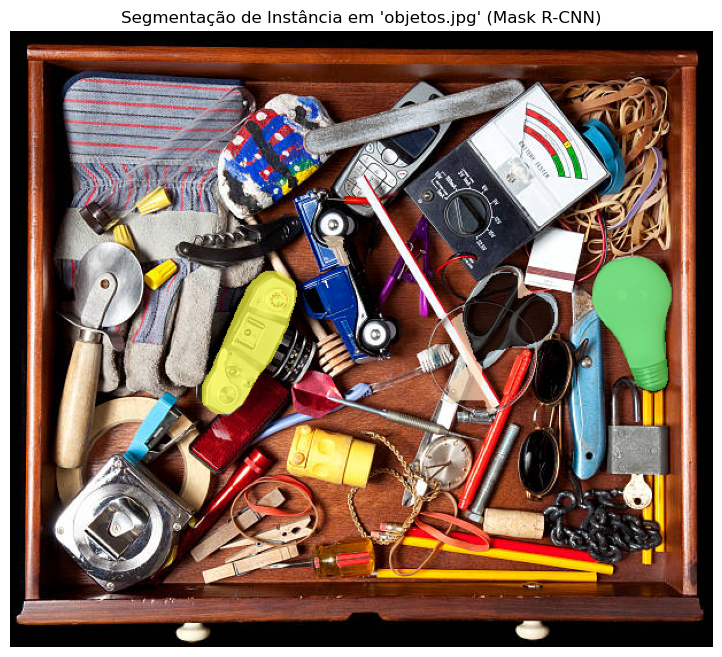


Instâncias segmentadas (com score > 0.5 ):
- scissors: 0.90
- spoon: 0.85
- cell phone: 0.61
- scissors: 0.54


In [20]:
import torch
import torchvision.models.detection as detection_models
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.utils as utils
import numpy as np # Para manipulação de máscaras
import random # Para cores

# Re-definindo o dispositivo, caso esta célula seja executada de forma independente em uma nova sessão.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Carrega o modelo Mask R-CNN pré-treinado (se ainda não estiver carregado)
# Se 'model_maskrcnn' já existe e está configurado, você pode comentar esta parte.
# No entanto, para garantir que a célula seja autossuficiente:
if 'model_maskrcnn' not in locals() or model_maskrcnn is None:
    model_maskrcnn = detection_models.maskrcnn_resnet50_fpn(weights=detection_models.MaskRCNN_ResNet50_FPN_Weights.COCO_V1)
    model_maskrcnn.eval()
    model_maskrcnn.to(device)
    print("Modelo Mask R-CNN pré-treinado carregado.")
else:
    print("Usando modelo Mask R-CNN previamente carregado.")

# Rótulos das classes do COCO (necessário para interpretar as 'labels' da predição)
# Se COCO_INSTANCE_CATEGORY_NAMES já foi definido em uma célula anterior, não precisa redefinir.
if 'COCO_INSTANCE_CATEGORY_NAMES' not in locals():
    COCO_INSTANCE_CATEGORY_NAMES = [
        '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
        'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
        'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
        'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
        'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
        'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
        'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
        'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
        'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]

image_path_segmentation = "objetos.jpg" 

try:
    img_seg_pil = Image.open(image_path_segmentation).convert("RGB")

    # Mostra a imagem original que será processada
    plt.figure(figsize=(8, 6))
    plt.imshow(img_seg_pil)
    plt.title(f"Imagem Original: {image_path_segmentation}")
    plt.axis('off')
    plt.show()

    transform_segmentation = T.Compose([T.ToTensor()])
    img_seg_tensor = transform_segmentation(img_seg_pil)
    img_seg_batch = img_seg_tensor.unsqueeze(0).to(device)

    # --- Realizando a Inferência para Segmentação de Instância ---
    with torch.no_grad():
        predictions_segmentation = model_maskrcnn(img_seg_batch)

    pred_seg = predictions_segmentation[0] # Saída para a primeira (e única) imagem no batch

    # Filtra detecções com score > 0.5 (ajuste conforme necessário)
    score_threshold_seg = 0.5
    confident_indices_seg = pred_seg['scores'] > score_threshold_seg
    
    filtered_masks_seg = pred_seg['masks'][confident_indices_seg].cpu().squeeze(1) 
    filtered_labels_indices_seg = pred_seg['labels'][confident_indices_seg].cpu().tolist()
    filtered_scores_seg = pred_seg['scores'][confident_indices_seg].cpu().tolist()
    
    filtered_labels_names_seg = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in filtered_labels_indices_seg]

    # Desenha as máscaras na imagem
    img_to_draw_masks_on = (T.ToTensor()(img_seg_pil) * 255).to(torch.uint8) # Imagem original como tensor uint8
    
    if len(filtered_masks_seg) > 0:
        boolean_masks = filtered_masks_seg > 0.5 # Binariza as máscaras (limiar de 0.5 para os pixels da máscara)
        
        mask_colors = []
        for _ in range(len(boolean_masks)):
            mask_colors.append(tuple(np.random.randint(50, 256, size=3).tolist()))

        img_with_masks = utils.draw_segmentation_masks(
            image=img_to_draw_masks_on,
            masks=boolean_masks,
            alpha=0.7, # Transparência da máscara
            colors=mask_colors
        )
    else:
        print("Nenhuma instância segmentada com confiança >", score_threshold_seg)
        img_with_masks = img_to_draw_masks_on # Mostra a imagem original se nada for detectado

    plt_img_with_masks = T.ToPILImage()(img_with_masks)

    plt.figure(figsize=(10, 8))
    plt.imshow(plt_img_with_masks)
    plt.title(f"Segmentação de Instância em '{image_path_segmentation}' (Mask R-CNN)")
    plt.axis('off')
    plt.show()
    
    print("\nInstâncias segmentadas (com score >", score_threshold_seg, "):")
    for label, score in zip(filtered_labels_names_seg, filtered_scores_seg):
        print(f"- {label}: {score:.2f}")

except FileNotFoundError:
    print(f"ERRO: Imagem '{image_path_segmentation}' não encontrada. Verifique o caminho e nome do arquivo.")
except Exception as e:
    print(f"Ocorreu um erro ao processar a segmentação de instância: {e}")

In [21]:
!pip install yolov5 pandas

  Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached psutil-7.0.0-cp36-abi3-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (22 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 1.9 MB/s eta 0:00:003.5 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.5/953.5 kB 4.3 MB/s eta 0:00:004.4 MB/s eta 0:00:01
Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 6.6 MB/s eta 0:00:00
   